Streaming output truncated to the last 5000 lines.
24/24 - 0s - loss: 3586.6287 - val_loss: 9264.6582 - 296ms/epoch - 12ms/step
Epoch 1503/4000
24/24 - 0s - loss: 3595.6399 - val_loss: 9354.6885 - 312ms/epoch - 13ms/step
Epoch 1504/4000
24/24 - 0s - loss: 3621.3801 - val_loss: 9513.4268 - 294ms/epoch - 12ms/step
Epoch 1505/4000
24/24 - 0s - loss: 3580.8887 - val_loss: 9253.3135 - 318ms/epoch - 13ms/step
Epoch 1506/4000
24/24 - 0s - loss: 3571.0732 - val_loss: 9385.6631 - 229ms/epoch - 10ms/step
Epoch 1507/4000
24/24 - 0s - loss: 3582.5872 - val_loss: 9291.4082 - 170ms/epoch - 7ms/step
Epoch 1508/4000
24/24 - 0s - loss: 3564.7266 - val_loss: 9313.2627 - 160ms/epoch - 7ms/step
Epoch 1509/4000
24/24 - 0s - loss: 3601.2900 - val_loss: 9421.0576 - 182ms/epoch - 8ms/step
Epoch 1510/4000
24/24 - 0s - loss: 3635.6047 - val_loss: 9321.9551 - 177ms/epoch - 7ms/step
Epoch 1511/4000
24/24 - 0s - loss: 3591.0879 - val_loss: 9379.4102 - 169ms/epoch - 7ms/step
Epoch 1512/4000
24/24 - 0s - loss: 3584.

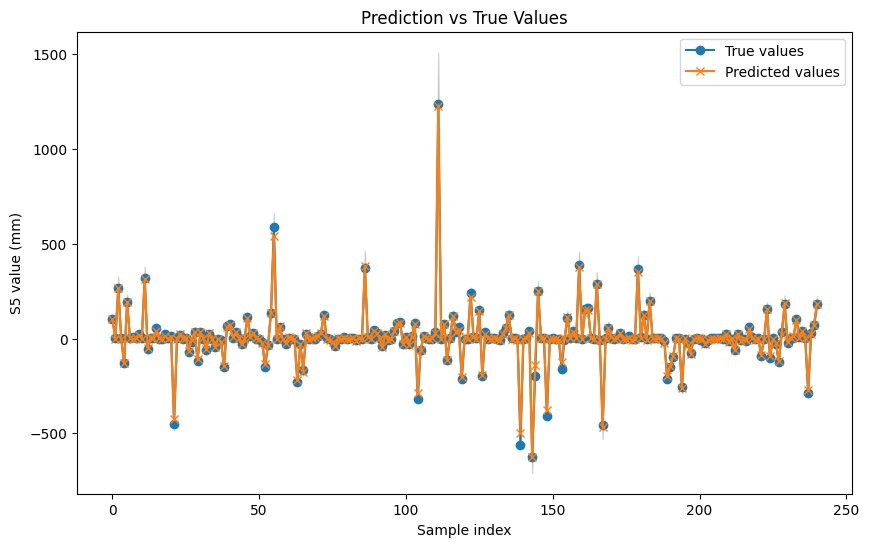

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
file_path = '/content/State(a)Healthy (1).xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Split the data into input and output
X = data[['S0 in mm', 'S1 in mm', 'S2 in mm', 'S3 in mm', 'S4 in mm']].values
y = data['S5 in mm'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Define the prior and posterior distributions for the Bayesian layers
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n)),
        tfp.layers.MultivariateNormalTriL(n)
    ])
    return posterior_model

# Build the Bayesian Neural Network model
def build_bnn_model(input_shape):
    model = tf.keras.Sequential([
        tfp.layers.DenseVariational(16, posterior, prior, activation='relu', input_shape=(input_shape,)),
        tfp.layers.DenseVariational(16, posterior, prior, activation='relu'),
        tfp.layers.DenseVariational(1, posterior, prior)
    ])
    return model

input_shape = X_train.shape[1]
bnn_model = build_bnn_model(input_shape)

# Define the negative log-likelihood and compile the model
def negloglik(y, rv_y):
    rv_y = tfp.distributions.Normal(loc=rv_y, scale=1.0)
    return -rv_y.log_prob(y)

# Use Adam optimizer with a lower learning rate
bnn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)

# Train the model
history = bnn_model.fit(X_train, y_train, epochs=4000, validation_split=0.2, verbose=2)

# Evaluate the model
bnn_model.evaluate(X_test, y_test, verbose=2)

# Predict the output
# We sample multiple times from the predictive distribution to estimate mean and stddev
num_samples = 100
y_pred_samples = np.array([bnn_model(X_test) for _ in range(num_samples)])
y_pred_mean = np.mean(y_pred_samples, axis=0)
y_pred_std = np.std(y_pred_samples, axis=0)

# Ensure y_pred_mean and y_pred_std are 1-dimensional
y_pred_mean = np.squeeze(y_pred_mean)
y_pred_std = np.squeeze(y_pred_std)

# Print shapes to verify
print("Shape of y_pred_mean:", y_pred_mean.shape)
print("Shape of y_pred_std:", y_pred_std.shape)

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True values', linestyle='-', marker='o')
plt.plot(y_pred_mean, label='Predicted values', linestyle='-', marker='x')
plt.fill_between(range(len(y_test)),
                 y_pred_mean - 2 * y_pred_std,
                 y_pred_mean + 2 * y_pred_std, color='gray', alpha=0.3)
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('S5 value (mm)')
plt.title('Prediction vs True Values')
plt.show()

Shape of y_pred_mean: (241,)
Shape of y_pred_std: (241,)


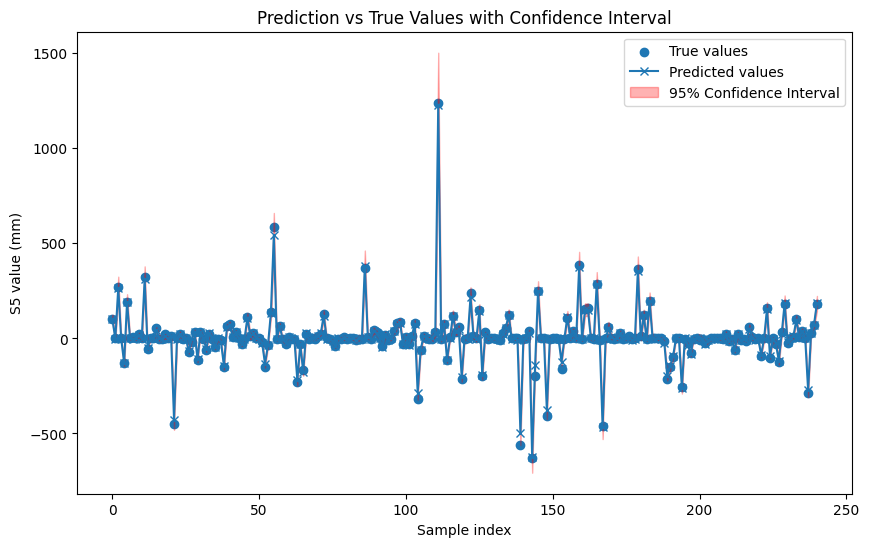

In [ ]:
# Ensure y_pred_mean and y_pred_std are 1-dimensional
y_pred_mean = np.squeeze(y_pred_mean)
y_pred_std = np.squeeze(y_pred_std)

# Print shapes to verify
print("Shape of y_pred_mean:", y_pred_mean.shape)
print("Shape of y_pred_std:", y_pred_std.shape)

# Plot the predictions against the actual values with confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='True values', marker='o')
plt.plot(y_pred_mean, label='Predicted values', linestyle='-', marker='x')
plt.fill_between(range(len(y_test)),
                 y_pred_mean - 1.96 * y_pred_std,
                 y_pred_mean + 1.96 * y_pred_std, color='red', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('S5 value (mm)')
plt.title('Prediction vs True Values with Confidence Interval')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
file_path = '/content/State(a)Healthy (1).xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

# Split the data into input and output
X = data[['S0 in mm', 'S1 in mm', 'S2 in mm', 'S3 in mm', 'S4 in mm']].values
y = data['S5 in mm'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Define the negative log-likelihood
def negloglik(y, rv_y):
    return -rv_y.log_prob(y)

# Build the Bayesian Neural Network model
def build_bnn_model(input_shape):
    model = tf.keras.Sequential([
        tfp.layers.DenseReparameterization(16, activation='relu', input_shape=(input_shape,)),
        tfp.layers.DenseReparameterization(16, activation='relu'),
        tfp.layers.DenseReparameterization(1)
    ])
    return model

input_shape = X_train.shape[1]
bnn_model = build_bnn_model(input_shape)

# Compile the model with negative log-likelihood
bnn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=negloglik)

# Train the model
history = bnn_model.fit(X_train, y_train, epochs=25, validation_split=0.2, verbose=2)

# Evaluate the model
bnn_model.evaluate(X_test, y_test, verbose=2)

# Predict the output
num_samples = 100
y_pred_samples = np.array([bnn_model(X_test) for _ in range(num_samples)])
y_pred_mean = np.mean(y_pred_samples, axis=0)
y_pred_std = np.std(y_pred_samples, axis=0)

# Ensure y_pred_mean and y_pred_std are 1-dimensional
y_pred_mean = np.squeeze(y_pred_mean)
y_pred_std = np.squeeze(y_pred_std)

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True values', linestyle='-', marker='o')
plt.plot(y_pred_mean, label='Predicted values', linestyle='-', marker='x')
confidence_level = 0.99
z_score = tfp.distributions.Normal(0., 1.).quantile((1 + confidence_level) / 2.)
plt.fill_between(range(len(y_test)),
                 y_pred_mean - z_score * y_pred_std,
                 y_pred_mean + z_score * y_pred_std, color='gray', alpha=0.3)
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('S5 value (mm)')
plt.title('Prediction vs True Values with 99% Confidence Interval')
plt.show()
